#### Readme
该NLP任务的主要目标为，通过纽约时报的新闻文本数据进行分析，预测未来可能发生的经济危机预警。

本任务的数据集为纽约时报1920-2020 的新闻标题和文本，以及1986-2012年美国发生的经济危机的时间戳（以年为单位）
输入为某一年份12个月的文本情感指标，输出为次年发生经济危机的概率

此任务涉及的主要方法包括：
1. 文本情感指标提取方法：采用金融情感词典计算对一条新闻样本的情感指标，按照时间进行平均，得到月度和年度情感指标
2. 情感与金融危机相关性评估：采用逻辑回归；考虑到经济危机往往具有一定的周期性，我们考虑多年多月份的新闻情感指标作为输入

In [1]:
%%time
import pyarrow.parquet as pq
import pandas as pd
import re
import nltk

from nltk import pos_tag # 词性
from nltk.tokenize import word_tokenize # 分词
from nltk.corpus import stopwords # 停用词
from nltk.stem import PorterStemmer, WordNetLemmatizer # 词干化，词态统一
from tqdm import tqdm  # 显示处理进度
tqdm.pandas(desc="Processing excerpts")

# run only once 第一次运行没下载要下载
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet') 
# nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) # 定义停用词

CPU times: total: 1.7 s
Wall time: 13 s


#### 1986-2012年的经济危机（US）

America(1986-2012) Romer&RomerCrisesAppendixA DerivationofNewMeasure.pdf

United States
- 1986:1 Credit disrupt.-minus
- 1990:1 Minor crisis-reg.
- 1990:2 Moderate crisis-minus
- 1991:1 Minor crisis-minus
- 1991:2 Credit disrupt.-plus
- 1992:1 Credit disrupt.-reg.
- 1998:2 Credit disrupt.-plus
- 2007:1 Credit disrupt.-minus
- 2007:2 Moderate crisis-minus
- 2008:1 Moderate crisis-plus
- 2008:2 Extreme crisis-reg.
- 2009:1 Major crisis-minus
- 2009:2 Moderate crisis-minus
- 2010:1 Minor crisis-plus
- 2010:2 Credit disrupt.-plus
- 2011:2 Credit disrupt.-reg.
- 2012:1 Credit disrupt.-minus
- 2012:2 Credit disrupt.-minus

In [2]:
# 假设我们有经济危机时间戳的数据列表
crisis_timestamps = [
    "1986:1 Credit disrupt.-minus",
    "1990:1 Minor crisis-reg.",
    "1990:2 Moderate crisis-minus",
    "1991:1 Minor crisis-minus",
    "1991:2 Credit disrupt.-plus",
    "1992:1 Credit disrupt.-reg.",
    "1998:2 Credit disrupt.-plus",
    "2007:1 Credit disrupt.-minus",
    "2007:2 Moderate crisis-minus",
    "2008:1 Moderate crisis-plus",
    "2008:2 Extreme crisis-reg.",
    "2009:1 Major crisis-minus",
    "2009:2 Moderate crisis-minus",
    "2010:1 Minor crisis-plus",
    "2010:2 Credit disrupt.-plus",
    "2011:2 Credit disrupt.-reg.",
    "2012:1 Credit disrupt.-minus",
    "2012:2 Credit disrupt.-minus"
]

# 定义危机的严重程度和修饰符的标量值
crisis_severity = {
    'Minor crisis': 1,
    'Moderate crisis': 2,
    'Major crisis': 3,
    'Extreme crisis': 4,
    'Credit disrupt.': 0.5  # 假设信用干扰不如危机那么严重
}

# 对修饰符进行数值调整
modifier_adjustment = {
    'minus': -0.1,
    'plus': 0.1,
    'reg.': 0.0
}

# 创建一个空的DataFrame来存储结果
crisis_data = pd.DataFrame(columns=['Year', 'Severity', 'Binary_Crisis'])

# 处理每个时间戳，填充DataFrame
for timestamp in crisis_timestamps:
    # 解析年份和描述
    year, _, description = timestamp.partition(':')
    year = int(year)  # 转换年份为整数
    # 解析危机类型和修饰符
    for crisis_type in crisis_severity:
        if crisis_type in description:
            severity_value = crisis_severity[crisis_type]
            # 找到修饰符并进行调整
            for modifier in modifier_adjustment:
                if modifier in description:
                    severity_value += modifier_adjustment[modifier]
                    break  # 找到修饰符后无需继续查找
            # 添加到DataFrame
            crisis_data = crisis_data._append({
                'Year': year,
                'Severity': severity_value,
                'Binary_Crisis': 1  # 如果记录中有危机描述则标为1
            }, ignore_index=True)
            break  # 危机类型已找到，无需继续其它类型的检查

# 确保年份是整数类型
crisis_data['Year'] = crisis_data['Year'].astype(int)
crisis_data['Binary_Crisis'] = crisis_data['Binary_Crisis'].astype(int)
# 输出结果
crisis_data

,Year,Severity,Binary_Crisis
0,1986,0.4,1
1,1990,1.0,1
2,1990,1.9,1
3,1991,0.9,1
4,1991,0.6,1
5,1992,0.5,1
6,1998,0.6,1
7,2007,0.4,1
8,2007,1.9,1
9,2008,2.1,1


In [3]:
# 首先，对同一年份的危机严重性分数求和
# 对Binary_Crisis采取最大值，因为如果有危机，Binary_Crisis应该是1
aggregated_crisis_data = crisis_data.groupby('Year').agg({'Severity': 'sum', 'Binary_Crisis': 'max'}).reset_index()

# 现在，aggregated_crisis_data 将有每个年份的危机严重性分数总和，且Binary_Crisis为1（如果那年发生了危机）
print(aggregated_crisis_data)

    Year  Severity  Binary_Crisis
0   1986       0.4              1
1   1990       2.9              1
2   1991       1.5              1
3   1992       0.5              1
4   1998       0.6              1
5   2007       2.3              1
6   2008       6.1              1
7   2009       4.8              1
8   2010       1.7              1
9   2011       0.5              1
10  2012       0.8              1


In [4]:
# Assume 'aggregated_crisis_data' is your original DataFrame
# Find the range of years you want to cover
full_year_range = range(aggregated_crisis_data['Year'].min(), aggregated_crisis_data['Year'].max() + 1)

# Create a DataFrame with all years in the range
all_years_df = pd.DataFrame(full_year_range, columns=['Year'])

# Merge with the existing crisis data
# This will keep all entries from all_years_df and match entries from crisis_data where available
complete_crisis_data = all_years_df.merge(aggregated_crisis_data, on='Year', how='left')

# Fill NaN values with 0 for 'Severity' and 'Binary_Crisis'
complete_crisis_data['Severity'].fillna(0, inplace=True)
complete_crisis_data['Binary_Crisis'].fillna(0, inplace=True)

# The resulting DataFrame will have all years filled, with 0 for missing years
print(complete_crisis_data)

    Year  Severity  Binary_Crisis
0   1986       0.4            1.0
1   1987       0.0            0.0
2   1988       0.0            0.0
3   1989       0.0            0.0
4   1990       2.9            1.0
5   1991       1.5            1.0
6   1992       0.5            1.0
7   1993       0.0            0.0
8   1994       0.0            0.0
9   1995       0.0            0.0
10  1996       0.0            0.0
11  1997       0.0            0.0
12  1998       0.6            1.0
13  1999       0.0            0.0
14  2000       0.0            0.0
15  2001       0.0            0.0
16  2002       0.0            0.0
17  2003       0.0            0.0
18  2004       0.0            0.0
19  2005       0.0            0.0
20  2006       0.0            0.0
21  2007       2.3            1.0
22  2008       6.1            1.0
23  2009       4.8            1.0
24  2010       1.7            1.0
25  2011       0.5            1.0
26  2012       0.8            1.0


In [5]:
%%time
# 加载数据
data = pd.read_parquet('nyt_data.parquet')
data.head()

CPU times: total: 27.7 s
Wall time: 44.2 s


,year,title,excerpt
0,1920,At last the Federal Reserve Board has issued r...,
1,1920,WILL TEST DOOR SERVICE.,Service Board to Further Examine I.R.T. Safety...
2,1920,Sanction for Chinese Contracts.,
3,1920,"LEADS FRAZIER BY 4,496.",Langer's Margin Falls in North Dakota--Gronna ...
4,1920,"CHICAGO, April 30.--With 300 suspicious charac...",Federal Agents and Police Round-- up Suspiciou...


In [6]:
# 假设 'data' 是已经加载包含所有年份新闻的 DataFrame
# 过滤出1980年及以后的数据
data_filtered = data[data['year'] >= 1982]

# 显示过滤后的数据头部
data_filtered.head()

,year,title,excerpt
11689540,1982,It was supposed to be a nice winter-vacation t...,
11689541,1982,A new breed of jumping horse is being develope...,
11689542,1982,WESTCHESTER residents who approved formation o...,we have to identify power sources and get more...
11689543,1982,"''DURING the 5,000 years of our history, dance...",
11689544,1982,The NCNB Corporation said it had received regu...,


In [7]:
%%time
# 取数据集的10%
data_sample = data.sample(frac=0.1, random_state=42)
# 查看数据集的样本大小
print("Sample size:", len(data_sample))

# 查看数据的前几行

# 查看数据的基本信息，包括列名、数据类型、非空值数量
data_sample.info()
# print(data_sample.head())

Sample size: 1737091
<class 'pandas.core.frame.DataFrame'>
Index: 1737091 entries, 871974 to 4934695
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   year     int64 
 1   title    object
 2   excerpt  object
dtypes: int64(1), object(2)
memory usage: 53.0+ MB
CPU times: total: 1.73 s
Wall time: 2.04 s


In [8]:
%%time
# 清洗文本数据
def clean_text(text):
    # 去除特殊字符和标点符号
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    # 小写化文本
    text = text.lower()
    return text

# 分词
def tokenize(text):
    words = nltk.word_tokenize(text)
    return words

# 分词和词形还原
def tokenize_and_lemmatize(text):
    tqdm.pandas(desc="Tokenizing")
    # 分词
    words = nltk.word_tokenize(text)
    # 词形还原
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return lemmatized_words

# 去停用词
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

# 词干化
def stem_tokens(tokens):
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]  # 添加进度条
    return stemmed_tokens

# NLTK词性标注函数
def nltk_tagger(text):
    # 分词
    tokens = word_tokenize(text)
    # 词性标注
    tagged_tokens = pos_tag(tokens)
    return tagged_tokens

CPU times: total: 0 ns
Wall time: 0 ns


In [9]:
%%time
# 一次性解决四个任务，优化代码，减少循环次数。建议apply
def preprocess_text(text):
    # 基本处理
    cleaned_text = clean_text(text)
    # 分词和词形还原
    lemmatized_tokens = tokenize_and_lemmatize(cleaned_text)
    # 去停用词
    non_stop_words = remove_stopwords(lemmatized_tokens)
    # 词干化
    stemmed_tokens = stem_tokens(non_stop_words)
    return stemmed_tokens

CPU times: total: 0 ns
Wall time: 0 ns


In [10]:
%%time
# 先将词性标注应用到数据集的每个'excerpt'
data_sample['tagged_excerpt'] = data_sample['excerpt'].progress_apply(nltk_tagger)

Processing excerpts: 100%|██████████████████████████████████████████████████| 1737091/1737091 [48:33<00:00, 596.26it/s]

CPU times: total: 48min
Wall time: 48min 33s


In [11]:
%%time
# 使用 progress_apply 代替 apply
data_sample['cleaned_excerpt'] = data_sample['excerpt'].progress_apply(preprocess_text)

Processing excerpts: 100%|██████████████████████████████████████████████████| 1737091/1737091 [32:37<00:00, 887.26it/s]


CPU times: total: 32min 22s
Wall time: 32min 37s


In [12]:
# %%time
# # 应用清洗函数
# data_sample['cleaned_excerpt'] = data_sample['excerpt'].apply(clean_text)

# %%time
# # 应用分词函数
# tqdm.pandas(desc="Tokenizing")# 使用tqdm来显示分词进度
# data_sample['tokenized_excerpt'] = data_sample['cleaned_excerpt'].progress_apply(tokenize_and_lemmatize)

# %%time
# # 去停用词
# data_sample['filtered_excerpt'] = data_sample['tokenized_excerpt'].apply(remove_stopwords)

# %%time
# # 词干化
# data_sample['stemmed_excerpt'] = data_sample['filtered_excerpt'].apply(stem_tokens)

In [13]:
%%time
# 查看处理后的数据
print(data_sample[['excerpt', 'cleaned_excerpt','tagged_excerpt']].head(1))

                                                  excerpt  \
871974  will sail from Rye, June 11; plans and personn...   

                                          cleaned_excerpt  \
871974  [sail, rye, june, 11, plan, personnel, b, putn...   

                                           tagged_excerpt  
871974  [(will, MD), (sail, VB), (from, IN), (Rye, NNP...  
CPU times: total: 219 ms
Wall time: 293 ms


In [14]:
%%time
# 加载Loughran-McDonald Master Dictionary
dictionary_path = 'Loughran-McDonald_MasterDictionary_1993-2021.xlsx'
lm_dict = pd.read_excel(dictionary_path)

CPU times: total: 18 s
Wall time: 20 s


In [15]:
%%time
# 将词典索引小写化
lm_dict['Word'] = lm_dict['Word'].str.lower()
lm_dict.set_index('Word', inplace=True)

# 然后在sentiment_score函数中使用小写的单词进行匹配
def sentiment_score(tagged_tokens, lm_dict):
    score = 0
    for word, tag in tagged_tokens:
        key = word.lower()  # 使用小写的词汇进行查找
        # 仅考虑词典中有的词
        if key in lm_dict.index:
            if lm_dict.loc[key, 'Positive'] > 0:
                score += 1
            elif lm_dict.loc[key, 'Negative'] > 0:
                score -= 1
    return score

# 注意确保传入的是词性标注过的列
data_sample['sentiment_score'] = data_sample['tagged_excerpt'].progress_apply(lambda x: sentiment_score(x, lm_dict))
# 查看结果
# 查看情感分析结果
print(data_sample[['excerpt', 'sentiment_score']].head())

Tokenizing: 100%|█████████████████████████████████████████████████████████| 1737091/1737091 [22:53:46<00:00, 21.07it/s]


                                                    excerpt  sentiment_score
871974    will sail from Rye, June 11; plans and personn...                0
3563372   Straus Says Project, Held Up for Investigation...               -1
11774055                                                                   0
11142793  rally, presided over by Gen Eurico Jesus Deus ...               -3
10942590  lost record in the majors. When he was tired t...               -8
CPU times: total: 22h 32min 28s
Wall time: 22h 54min 2s


In [16]:
# # 金融词频（总词频）统计，你想要的可能是每一年的词频统计，那么请你筛选出年份，然后把下面的data_sample替换为你筛选好的年份即可
# from collections import Counter
# # 提取词典中的所有词汇
# all_words = lm_dict.index.tolist()
# # 初始化一个词频统计字典
# all_words_count = Counter()

In [17]:
# %%time
# # 遍历数据集中的文本
# for excerpt in data_sample['cleaned_excerpt']:
#     # 假设cleaned_excerpt已经是分词后的结果
#     words = excerpt  # 如果cleaned_excerpt不是分词后的列表，需要先分词
#     # 更新统计字典
#     all_words_count.update(w for w in words if w in all_words)

# # 输出最常见的词及其频率
# print(all_words_count.most_common())

In [18]:
%%time
# 计算每一年的情感得分平均值
annual_sentiment_score = data_sample.groupby('year')['sentiment_score'].mean()

CPU times: total: 93.8 ms
Wall time: 143 ms


In [19]:
# 构建特征集和标签集
features = []
labels = []
for year in range(1986, 2012):  # 2012是最后一个有危机标签的年份
    if year + 1 in complete_crisis_data['Year'].values:  # 确保我们有下一年的危机信息
        features.append([annual_sentiment_score[year-4],annual_sentiment_score[year-3],annual_sentiment_score[year-2], annual_sentiment_score[year-1], annual_sentiment_score[year]])
        labels.append(1 if year + 1 in complete_crisis_data[complete_crisis_data['Binary_Crisis'] == 1]['Year'].values else 0)

# 分割数据集
# 假设我们使用前25年的数据作为训练集，剩下的数据作为测试集
train_features = features[:25]
train_labels = labels[:25]
test_features = features[25:]
test_labels = labels[25:]

In [20]:
%%time
# 训练逻辑回归模型
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(features, labels)

CPU times: total: 31.2 ms
Wall time: 1.54 s


LogisticRegression()

In [21]:
# 评估模型
from sklearn.metrics import classification_report
predictions = model.predict(features)
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.62      1.00      0.76        16
           1       0.00      0.00      0.00        10

    accuracy                           0.62        26
   macro avg       0.31      0.50      0.38        26
weighted avg       0.38      0.62      0.47        26



F:\Anaconda3\envs\ECTnet\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda3\envs\ECTnet\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda3\envs\ECTnet\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
%%time
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# 假设 model 是你的逻辑回归模型
# 假设 features 是特征集的数组或列表
# 假设 true_labels 是真实标签的数组或列表

# 获取预测概率
predicted_probabilities = model.predict_proba(features)[:,1]

# 获取年份
years = range(1986, 2012)  # 根据你的实际年份范围调整
predicted_probabilities

CPU times: total: 422 ms
Wall time: 3.05 s


array([0.42513257, 0.42724061, 0.42832224, 0.43043341, 0.42648541,
       0.41714446, 0.41440202, 0.41454904, 0.41378705, 0.41271801,
       0.39094083, 0.35154052, 0.31631946, 0.30282347, 0.31647061,
       0.33303054, 0.31771389, 0.29669834, 0.28737353, 0.32013485,
       0.36849912, 0.41896747, 0.44876404, 0.44546494, 0.44422565,
       0.43088994])

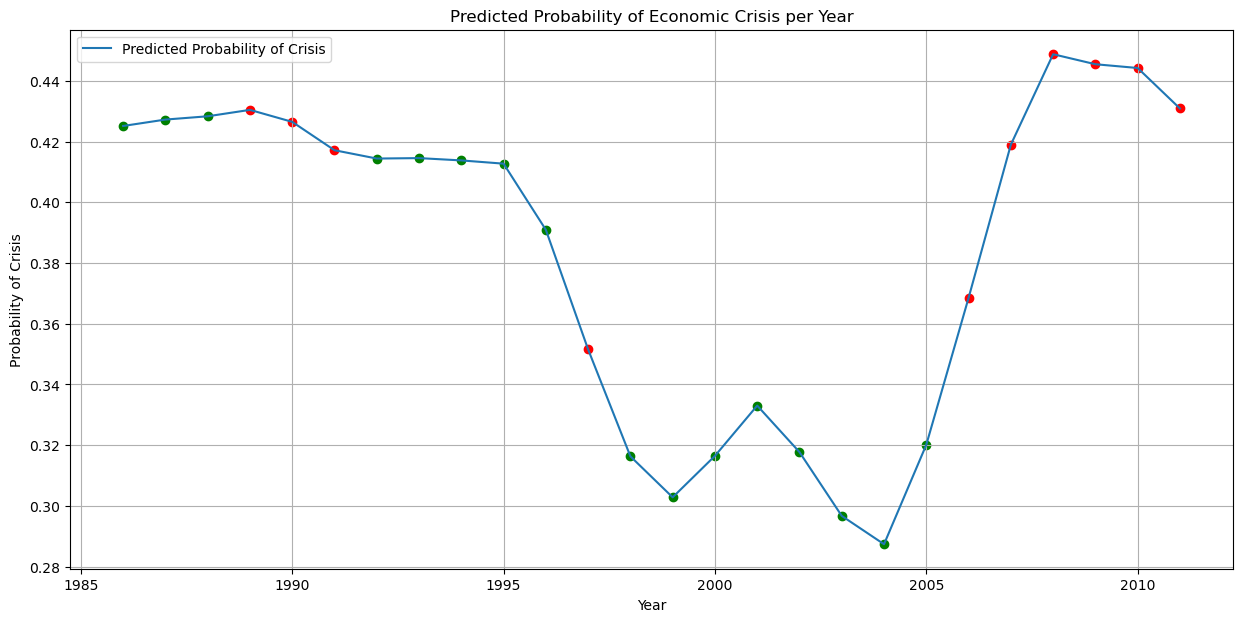

CPU times: total: 469 ms
Wall time: 1.29 s


In [23]:
%%time
# 绘制预测概率与实际情况
plt.figure(figsize=(15, 7))
plt.plot(years, predicted_probabilities, label='Predicted Probability of Crisis')

# 标记实际危机情况
for i, year in enumerate(years):
    if labels[i] == 1:
        plt.scatter(year, predicted_probabilities[i], color='red')  # 危机发生
    else:
        plt.scatter(year, predicted_probabilities[i], color='green')  # 无危机

# 添加图表元素
plt.xlabel('Year')
plt.ylabel('Probability of Crisis')
plt.title('Predicted Probability of Economic Crisis per Year')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
%%time
# 线性回归
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
# 假设 annual_sentiment_score 是一个包含所有年份情感得分平均值的 pandas Series
# 假设 complete_crisis_data 是一个包含所有年份危机严重性的 DataFrame

# 构建特征集和标签集
linear_features = []
linear_labels = []

for year in range(1986, 2012):
    # 使用前五年的情感得分平均值作为特征
    linear_features.append([annual_sentiment_score[year-4],annual_sentiment_score[year-3],annual_sentiment_score[year-2],annual_sentiment_score[year-1],annual_sentiment_score[year]])
    # 下一年的经济危机严重性作为标签
    label = complete_crisis_data[complete_crisis_data['Year'] == year+1]['Severity'].values[0]
    linear_labels.append(label)

# 将特征和标签转换成 NumPy 数组
linear_features = np.array(linear_features)
linear_labels = np.array(linear_labels)
print(len(linear_features),len(linear_labels))

26 26
CPU times: total: 31.2 ms
Wall time: 19.9 ms


In [25]:
%%time
# 分割数据集为训练集和测试集
# 例如，使用1986-2005年数据训练，2005-2007年数据测试
train_features = linear_features[:]
train_labels = linear_labels[:]
# test_features = features[20:]
# test_labels = labels[20:]

# 训练线性回归模型
model = LinearRegression()
model.fit(train_features, train_labels)

# 进行预测
predictions = model.predict(train_features)

CPU times: total: 15.6 ms
Wall time: 5.47 s


In [26]:
%%time
# 评估模型
mse = mean_squared_error(train_labels, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.9647082207919347
CPU times: total: 0 ns
Wall time: 1.99 ms


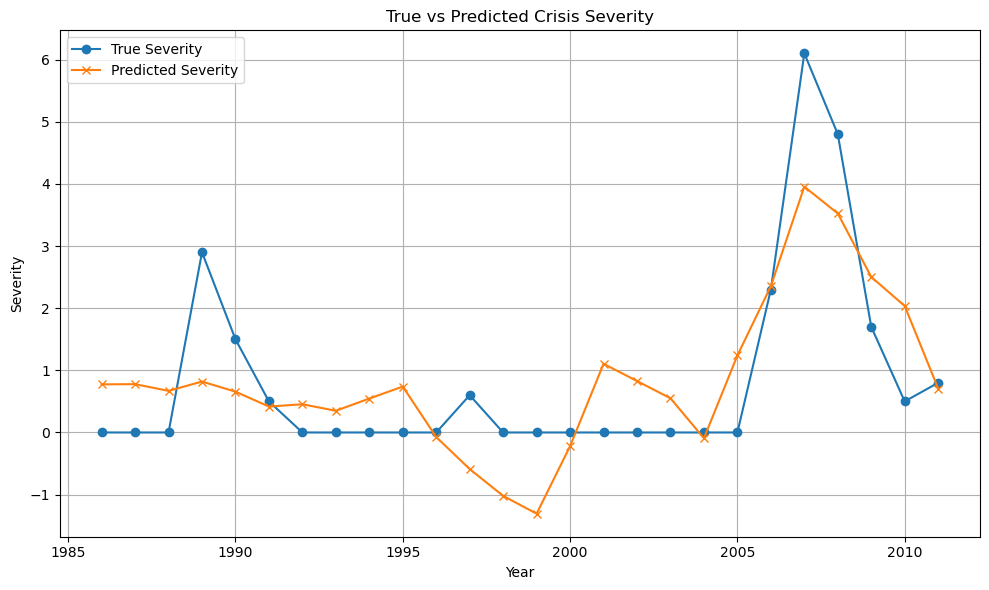

CPU times: total: 266 ms
Wall time: 256 ms


In [27]:
%%time
import matplotlib.pyplot as plt

# 假设 linear_labels 和 predictions 分别是真实标签和预测结果

# 确保 linear_labels 和 predictions 的长度相同
# 使用 Matplotlib 绘制折线图
years = range(1986, 2012)  # 确保年份范围正确
plt.figure(figsize=(10, 6))

# 绘制真实严重性
plt.plot(years, linear_labels, label='True Severity', marker='o', linestyle='-')

# 绘制预测严重性
plt.plot(years, predictions, label='Predicted Severity', marker='x', linestyle='-')

plt.xlabel('Year')
plt.ylabel('Severity')
plt.title('True vs Predicted Crisis Severity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()